In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt

np.warnings = warnings

ROOT_DIR = Path('../..')
sys.path.append(os.path.abspath(os.path.join('../src')))
sys.path.append(os.path.abspath(os.path.join('..')))
import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.model_evaluation as me
reload(me)

<module 'src.model_evaluation' from '/home/labadmin/work/data-science-capstone-project/Kha Huynh/src/model_evaluation.py'>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

import tensorflow as tf

2023-10-22 00:07:57.828289: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 00:07:57.829817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 00:07:57.856934: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 00:07:57.857255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 00:07:58.349438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Data Preparation - Train val test split

In [3]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t8_top20_sequence.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_val_df, _, _ = df_split(x_train_df,  # dropping the target column for X values
                                        y_train_df,
                                        test_size=0.15,
                                        )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)
x_val_df, x_val_count, y_val_df = create_data_df(x_val_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values
val_gendernum = x_val_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_val = imputer.transform(x_val_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))
x_val = np.column_stack((x_val, val_gendernum))

x_train_norm = x_train
x_test_norm = x_test

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels

In [7]:
def data_preparation():
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)
  val_data, act_val = ts_to_secs(x_val, x_val_count, y_val_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())
  print("[INFO] -- Shape of Validation Sections:")
  print(val_data.bounding_shape())

  return train_data, act_train, test_data, act_test, val_data, act_val

In [8]:
x_train, y_train, x_test, y_test, x_val, y_val = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([32800    21    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9648   18   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([5789   17   24], shape=(3,), dtype=int64)


# Model Definition

In [9]:
import src.model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

# sample_weights = mask_train
sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

# sample_weights_test = mask_test
sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [12]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []
models = []

# Simple LSTM

In [13]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [14]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = LSTM_model()
models.append(model)

In [15]:
for i, model in enumerate(models):
  print(f"----------------Start model {i}---------------------")

  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)

  checkpointer = ModelCheckpoint(filepath = f'models/t8_model.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=10, restore_best_weights=True)
  callbacks_list = [lr_scheduler, early_stop, checkpointer]
  # callbacks_list = [lr_scheduler, checkpointer]
  m = model.fit(x_train,y_train,
                sample_weight=sample_weights,
                # class_weight=me.get_class_weights(y_train_df),
                epochs=50, batch_size=64, verbose=1,
                validation_data=(x_val, y_val),
                callbacks=callbacks_list)
  m_hist.append(m)

----------------Start model 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          22784     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 55938 (218.51 KB)
Trainable params: 55938 (218.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


513/513 [==============================] - 6s 12ms/step - loss: 0.5433 - accuracy: 0.7649 - auc: 0.7963 - val_loss: 0.5598 - val_accuracy: 0.7528 - val_auc: 0.7917 - lr: 9.0484e-04
Epoch 3/50
513/513 [==============================] - 6s 11ms/step - loss: 0.5239 - accuracy: 0.7671 - auc: 0.8158 - val_loss: 0.5171 - val_accuracy: 0.7662 - val_auc: 0.8222 - lr: 8.1873e-04
Epoch 4/50
513/513 [==============================] - 6s 12ms/step - loss: 0.5140 - accuracy: 0.7677 - auc: 0.8244 - val_loss: 0.5251 - val_accuracy: 0.7630 - val_auc: 0.8177 - lr: 7.4082e-04
Epoch 5/50
513/513 [==============================] - 6s 11ms/step - loss: 0.5065 - accuracy: 0.7670 - auc: 0.8298 - val_loss: 0.5221 - val_accuracy: 0.7663 - val_auc: 0.8217 - lr: 6.7032e-04
Epoch 6/50
513/513 [==============================] - 6s 11ms/step - loss: 0.5005 - accuracy: 0.7683 - auc: 0.8328 - val_loss: 0.4906 - val_accuracy: 0.7789 - val_auc: 0.8436 - lr: 6.0653e-04
Epoch 7/50
513/513 [==============================]

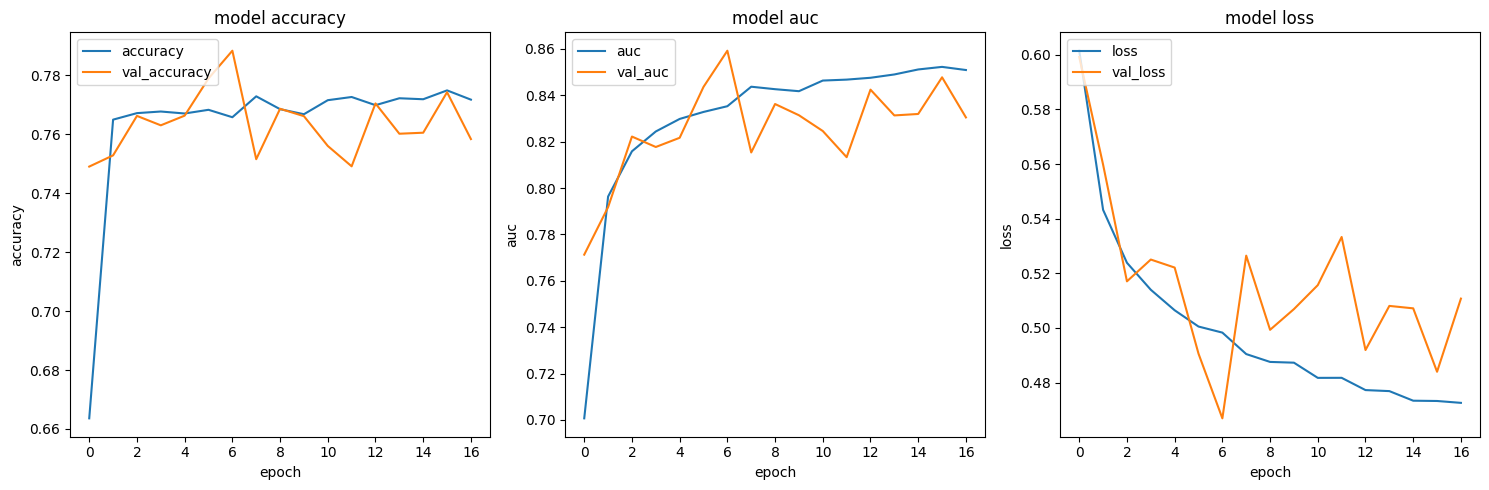

In [16]:
import matplotlib.pyplot as plt

for i, _ in enumerate(m_hist):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(m_hist[i].history['accuracy'])
  plt1.plot(m_hist[i].history['val_accuracy'])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(m_hist[i].history['auc'])
  plt2.plot(m_hist[i].history['val_auc'])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(m_hist[i].history['loss'])
  plt3.plot(m_hist[i].history['val_loss'])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.tight_layout()
  plt.show()

Inference:
302/302 [==============================] - 1s 4ms/step


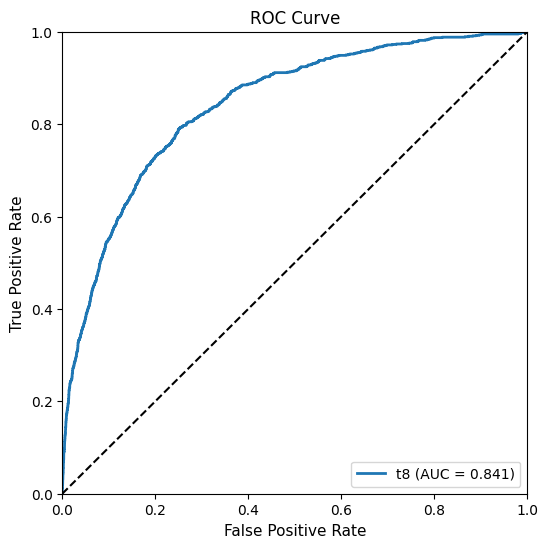

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,AUC
0,t8,0.764,0.762,0.307,0.306,0.718,0.715,0.43,0.429,0.841


In [11]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['t8']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"models/t8_model.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)

# TimeSHAP

In [18]:
from keras.models import load_model

print("Inference:")
model = load_model(f"t8_model_best_acc7585_f14262.hdf5")

Inference:


In [19]:
f = lambda x: model.predict(x)[:, 1]
raw_model_features = x_train_df.columns
model_features = [f"p_normalize_{x}" for x in np.delete(raw_model_features, [0,1,3,4, 5, -1])]
model_features.append(f"p_normalize_{raw_model_features[3]}")

In [20]:
d_train_normalized = pd.concat([x_train_df, pd.DataFrame(x_train_norm, columns=model_features)], axis=1)
d_test_normalized = pd.concat([x_test_df, pd.DataFrame(x_test_norm, columns=model_features)], axis=1)

In [21]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(d_train_normalized, numerical_feats=model_features, categorical_feats=[])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [22]:
average_event

,p_normalize_AGE,p_normalize_ITEMID_50813,p_normalize_ITEMID_50821,p_normalize_ITEMID_50862,p_normalize_ITEMID_50882,p_normalize_ITEMID_50885,p_normalize_ITEMID_50893,p_normalize_ITEMID_50902,p_normalize_ITEMID_50912,p_normalize_ITEMID_50931,...,p_normalize_ITEMID_51237,p_normalize_ITEMID_51244,p_normalize_ITEMID_51256,p_normalize_ITEMID_51265,p_normalize_ITEMID_51274,p_normalize_ITEMID_51277,p_normalize_ITEMID_51279,p_normalize_ITEMID_51301,p_normalize_SOFA,p_normalize_GENDER_NUM
0,0.203511,-0.010197,-0.100406,0.008998,0.025074,-0.030673,0.009051,0.005366,-0.014891,-0.159366,...,0.016822,-0.07763,0.08821,-0.086321,-0.035212,0.005618,0.019331,-0.041434,-0.058137,0.0


In [23]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(d_train_normalized, numerical_feats=model_features, categorical_feats=[],model_features=model_features, entity_col='HADM_ID')

AssertionError: All sequences must be the same length

In [ ]:
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=480)

## Local Explanations

In [ ]:
ids_for_test = [189380, 112077, 107064, 109235] # first 2 hadm_id are sepsis case, last 2 are non-sepsis
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'].isin(ids_for_test)]
labels = d_test_normalized[d_test_normalized.HADM_ID.isin(ids_for_test)].drop_duplicates(['HADM_ID'])[['HADM_ID', 'IS_SEPSIS']]

# select model features only
# pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = [np.expand_dims(pos_x_pd[pos_x_pd.HADM_ID==x][model_features].to_numpy().copy(), axis=0) for x in ids_for_test]

In [ ]:
_, df_desc_labitems,_ = dataLoader.load_descriptions()

In [ ]:
plot_feats_1 = {model_features[0]:model_features[0][12:]}
plot_feats_2 = {x:x[12:] for x in model_features[-2:]}
plot_feats_3 = {x: df_desc_labitems[df_desc_labitems.ITEMID == int(x[19:])].LABEL.values[0] for x in model_features[1:-2]}
plot_feats = {**plot_feats_1, **plot_feats_3, **plot_feats_2}

In [ ]:
from timeshap.explainer import local_report, local_pruning, local_feat
from timeshap.plot import plot_feat_barplot, plot_global_feat, feature_level
import altair  as alt
sequence_id_feat = 'HADM_ID'

def plot_local_features(ids_for_test, pos_x_data, labels):
  objects = len(ids_for_test)
  plots = []
  for pos_id in list(range(0,objects)):
    hadm_id = ids_for_test[pos_id]
    pos_x = pos_x_data[pos_id]
    label = 'SEPSIS' if labels[labels.HADM_ID == hadm_id]['IS_SEPSIS'].values==1 else 'NON-SEPSIS'
    pruning_dict = {'tol': 0.025,}
    coal_plot_data, coal_prun_idx = local_pruning(f, pos_x, pruning_dict, average_event, hadm_id, sequence_id_feat, False)
    # coal_prun_idx is in negative terms
    pruning_idx = pos_x.shape[1] + coal_prun_idx

    feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
    feature_data = local_feat(f, pos_x, feature_dict, hadm_id, sequence_id_feat, average_event, pruning_idx)
    feat_plot_0 = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
    feat_plot_0 = feat_plot_0.properties(width=500, height = {'step': 15}, title=f'HADM_ID: {hadm_id}, {label}')
    feat_plot_0 = feat_plot_0.encode(
        x=alt.X('Shapley Value', type='quantitative', scale=alt.Scale(domain=[-0.5, 0.5]))
    )
    plots.append(feat_plot_0)
  return plots

In [ ]:
feat_plots = plot_local_features(ids_for_test, pos_x_data, labels)

1/1 [==============================] - 0s 21ms/step
Unable to prune sequence.
1000/1000 [==============================] - 2s 2ms/step


In [ ]:
(feat_plots[0] | feat_plots[1]) & (feat_plots[2] | feat_plots[3])

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.VConcatChart(...)

### All local plots

In [ ]:
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'] == ids_for_test[0]]

# select model features only
pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = np.expand_dims(pos_x_data.to_numpy().copy(), axis=0)

In [ ]:
from timeshap.explainer import local_report

pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 32000}
feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f, pos_x_data, pruning_dict, event_dict, feature_dict, cell_dict=cell_dict, entity_uuid=ids_for_test, entity_col='HADM_ID', baseline=average_event)

Assuming all features are model features
16/16 [==============================] - 0s 2ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

## Global Explanations

In [ ]:
from timeshap.explainer import global_report

time_feat = 'CHARTTIME'

a = d_test_normalized[d_test_normalized.IS_SEPSIS==1].groupby('HADM_ID')['HADM_ID'].count().reset_index(name='COUNT')
a = a[a.COUNT==1]

pos_dataset = d_test_normalized[~d_test_normalized['HADM_ID'].isin(a.HADM_ID)]
schema = list(pos_dataset.columns)
# pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
# event_dict = {'path': 'outputs/event_all_tf.csv', 'rs': 42, 'nsamples': 32000}
# feature_dict = {'path': 'outputs/feature_all_tf.csv', 'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats,}

pruning_dict = {'tol': [0.05, 0.075]}
event_dict = {'rs': 42, 'nsamples': 32000}
feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats,}
prun_stats, global_plot = global_report(f, pos_dataset, pruning_dict, event_dict, feature_dict, average_event, model_features, schema, sequence_id_feat, time_feat, )
prun_stats
global_plot

In [ ]:
global_plot